In [1]:
import pandas as pd
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM, AutoModelForMaskedLM, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification
from tqdm.auto import tqdm
import evaluate
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
import json
from sklearn.model_selection import train_test_split

from TextDataset import TextDataset
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

from matplotlib import pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

mps


## Config tokenizer and model

#### Call BertModel

In [3]:
# # Create a config with the desired settings
# config = BertConfig.from_pretrained('bert-base-uncased', output_attentions=True, num_labels=2)

# # Load the model with the custom config
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# new_tokens = ['\n', '(.)', '(..)', '(...)', 'xxx']
# tokenizer.add_tokens(new_tokens)
# model.resize_token_embeddings(len(tokenizer))

#### Call AutoModel

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

# Add your custom tokens
new_tokens = ['\n', '(.)', '(..)', '(...)', 'xxx']
tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

/Users/alan/anaconda3/envs/capstone/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(29001, 768, padding_idx=0)

## Load Data

In [5]:
def load_data(json_file):
    with open(json_file, 'r') as f:
        data_list = json.load(f)
    lines = [item['line'] for item in data_list]
    labels = [item['label'] for item in data_list]
    return lines, labels

lines, labels = load_data("../data/clean_v1.json")
lines_train, lines_test, labels_train, labels_test = train_test_split(
        lines, labels, test_size=0.2, random_state=42
    )

In [5]:
train = pd.read_csv("../data/train_v1_400.csv", index_col = "index")
lines_train = train["line"].to_list()
labels_train = train["label"].to_list()

test = pd.read_csv("../data/test_v1_149.csv", index_col = "index")
lines_test = test["line"].to_list()
labels_test = test["label"].to_list()

In [6]:
train_dataset = TextDataset(lines_train, labels_train, tokenizer)
test_dataset = TextDataset(lines_test, labels_test, tokenizer)


train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)
test_dataloader = DataLoader(test_dataset, batch_size=4)

## Set Up Model

In [7]:
optimizer = AdamW(model.parameters(), lr=5e-5)

# Learning rate scheduler
num_epochs = 15
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29001, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Train

In [8]:
def model_accuracy(model, dataloader, device):
    """Evaluates the model on the given dataloader and returns accuracy"""
    model.eval()  # Set the model to evaluation mode

    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(**batch)
            logits = outputs.logits

            # Get predictions
            predictions = torch.argmax(logits, dim=-1)
            labels = batch['labels']

            # Update correct predictions and totals
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            # Collect all predictions and labels for other metrics
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions

    return accuracy

In [11]:
progress_bar = tqdm(range(num_training_steps))

for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

        progress_bar.update(1)
        
    epoch_accuracy = model_accuracy(model, test_dataloader, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}")

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15, Loss: 42.3343, Accuracy: 0.77
Epoch 2/15, Loss: 42.6167, Accuracy: 0.77
Epoch 3/15, Loss: 42.1916, Accuracy: 0.77
Epoch 4/15, Loss: 42.7903, Accuracy: 0.77
Epoch 5/15, Loss: 44.6043, Accuracy: 0.77
Epoch 6/15, Loss: 42.5890, Accuracy: 0.77
Epoch 7/15, Loss: 43.8558, Accuracy: 0.77
Epoch 8/15, Loss: 43.0291, Accuracy: 0.77
Epoch 9/15, Loss: 41.9181, Accuracy: 0.77
Epoch 10/15, Loss: 45.0943, Accuracy: 0.77
Epoch 11/15, Loss: 43.6438, Accuracy: 0.77
Epoch 12/15, Loss: 43.0983, Accuracy: 0.77
Epoch 13/15, Loss: 47.2301, Accuracy: 0.77
Epoch 14/15, Loss: 44.2600, Accuracy: 0.77
Epoch 15/15, Loss: 44.2615, Accuracy: 0.77


## Test

Accuracy:	 0.7651006711409396
Precision:	 0.797430641563944
Recall:	 0.7651006711409396
F1 Score:	 0.7736008227607076


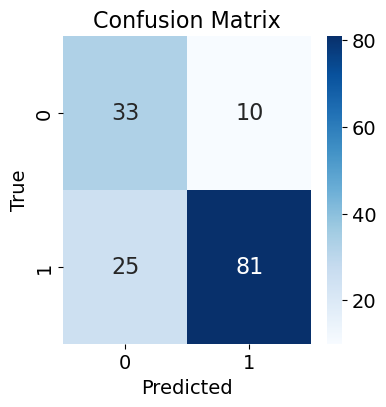

In [12]:
# Load the metrics you want to compute
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Initialize lists to store all predictions and references
all_predictions = []
all_references = []

model.eval()  # Set the model to evaluation mode
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Move predictions and references to CPU and convert to numpy arrays
    predictions_cpu = predictions.cpu().numpy()
    references_cpu = batch["labels"].cpu().numpy()

    # Store predictions and references
    all_predictions.extend(predictions_cpu)
    all_references.extend(references_cpu)

# Compute all metrics at once using the full predictions
accuracy = accuracy_metric.compute(predictions=all_predictions, references=all_references)
precision = precision_metric.compute(predictions=all_predictions, references=all_references, average='weighted')
recall = recall_metric.compute(predictions=all_predictions, references=all_references, average='weighted')
f1 = f1_metric.compute(predictions=all_predictions, references=all_references, average='weighted')
print("Accuracy:\t", accuracy['accuracy'])
print("Precision:\t", precision['precision'])
print("Recall:\t", recall['recall'])
print("F1 Score:\t", f1['f1'])

# Compute and print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_references, all_predictions)
plt.figure(figsize=(4,4))
plt.rcParams.update({'font.size': 14})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()
